In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from tqdm import tqdm, trange

import flygym.util.vision as vision
from flygym.envs.nmf_mujoco import MuJoCoParameters
from visual_taxis import MovingObjArena, NMFVisualTaxis

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [3]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

In [4]:
arena = MovingObjArena(obj_spawn_pos=(5, 3, 0), move_mode="s_shape", move_speed=30)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
sim = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)


In [5]:
obs, info = sim.reset()

for i in range(10):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    print(reward, terminated, truncated, info)

sim.reset()

obs_hist = [obs]
visual_hist = [sim.curr_visual_input]
ball_pos_hist = []
for i in range(30):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    obs_hist.append(obs)
    ball_pos_hist.append(sim.arena.ball_pos[:2])
    if i < 9:
        visual_hist.append(sim.curr_visual_input)
    print(reward, terminated, truncated, info)

sim.save_video("visual_taxis_test.mp4")

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


-0.9809550654287742 False False {'state_desc': 'seeking', 'unadjusted reward': -0.9809550654287742, 'offset_from_ideal': 1.811906960274075}
-0.5371221605670886 False False {'state_desc': 'seeking', 'unadjusted reward': -0.5371221605670886, 'offset_from_ideal': 2.3490291208411636}
-0.6850290252008433 False False {'state_desc': 'seeking', 'unadjusted reward': -0.6850290252008433, 'offset_from_ideal': 3.034058146042007}
-0.6900250538728336 False False {'state_desc': 'seeking', 'unadjusted reward': -0.6900250538728336, 'offset_from_ideal': 3.7240831999148405}
-0.6887347594173168 False False {'state_desc': 'seeking', 'unadjusted reward': -0.6887347594173168, 'offset_from_ideal': 4.412817959332157}
-0.5960210080809816 False False {'state_desc': 'seeking', 'unadjusted reward': -0.5960210080809816, 'offset_from_ideal': 5.008838967413139}
-0.519960249883173 False False {'state_desc': 'seeking', 'unadjusted reward': -0.519960249883173, 'offset_from_ideal': 5.528799217296312}
-0.3642882162721044 

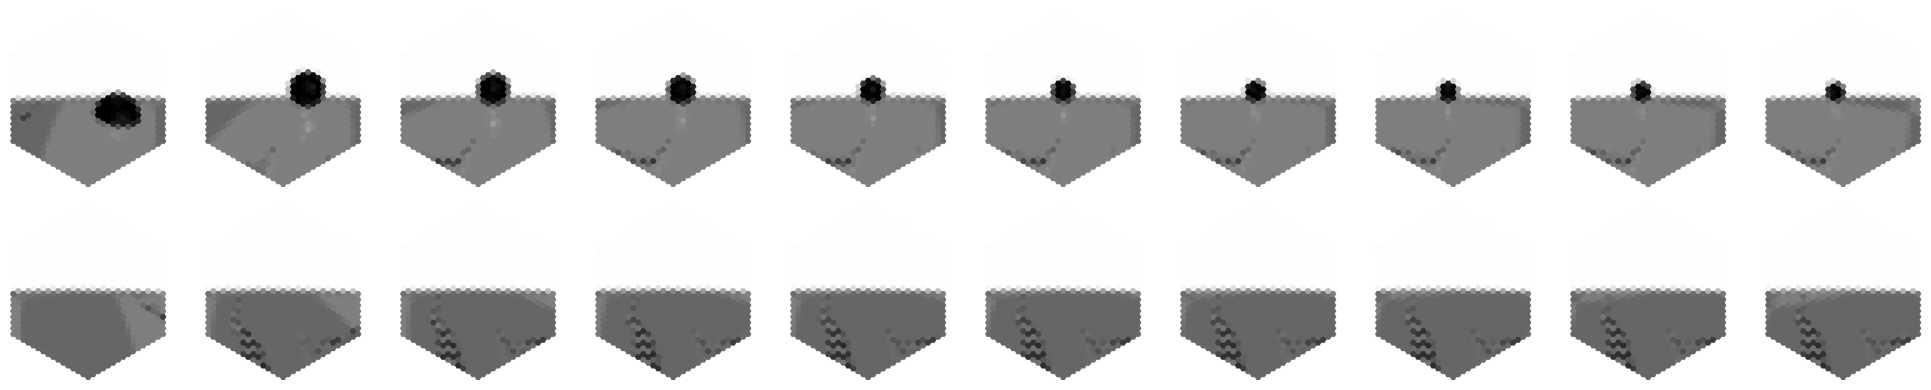

In [6]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4), tight_layout=True)
for i, visual_obs in enumerate(visual_hist):
    human_readable_img_left = vision.hex_pxls_to_human_readable(visual_obs[0], vision.ommatidia_id_map)
    axs[0, i].imshow(human_readable_img_left, cmap="gray", vmin=0, vmax=255)
    axs[0, i].axis("off")
    human_readable_img_right = vision.hex_pxls_to_human_readable(visual_obs[1], vision.ommatidia_id_map)
    axs[1, i].imshow(human_readable_img_right, cmap="gray", vmin=0, vmax=255)
    axs[1, i].axis("off")

(-0.01, 0.3)

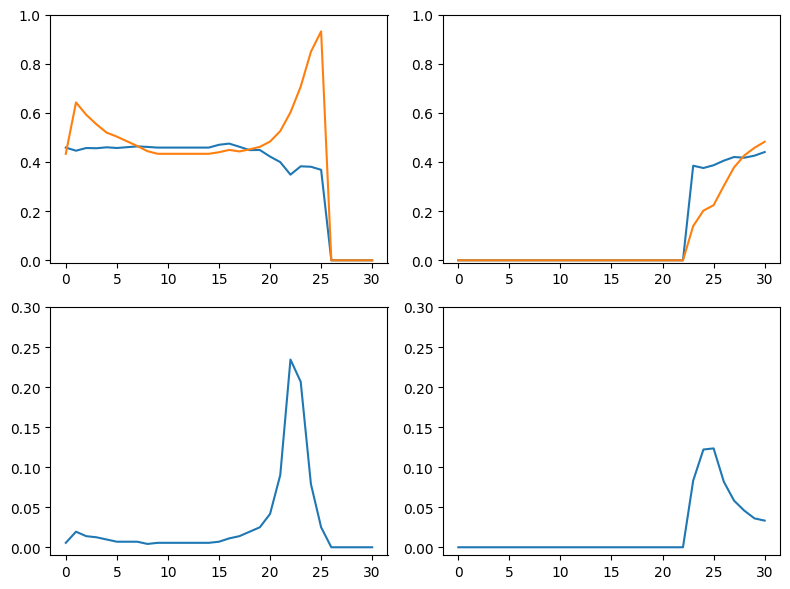

In [7]:
obs_hist = np.array(obs_hist)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 0].set_ylim(-0.01, 1)
axs[1, 0].plot(obs_hist[:, 2])
axs[1, 0].set_ylim(-0.01, 0.3)

axs[0, 1].plot(obs_hist[:, 3])
axs[0, 1].plot(obs_hist[:, 4])
axs[0, 1].set_ylim(-0.01, 1)
axs[1, 1].plot(obs_hist[:, 5])
axs[1, 1].set_ylim(-0.01, 0.3)

In [8]:

arena = MovingObjArena(obj_spawn_pos=(5, 3, 0), move_mode="s_shape", move_speed=30)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)
check_env(task)

In [9]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

model = sb3.SAC("MlpPolicy", env=task, policy_kwargs={"net_arch": [16, 16]}, verbose=2, learning_rate=0.01)
model.learn(total_timesteps=10_000, progress_bar=True)

model.save("models/object_tracking_sac")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.75     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 37       |
|    total_timesteps | 39       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.75     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 60       |
|    total_timesteps | 62       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.83     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1        |
|    time_elapsed    | 92       |
|    total_timesteps | 94       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.56     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1        |
|    time_elapsed    | 119      |
|    total_timesteps | 121      |
| train/             |          |
|    actor_loss      | -0.227   |
|    critic_loss     | 29.9     |
|    ent_coef        | 0.827    |
|    ent_coef_loss   | -0.639   |
|    learning_rate   | 0.01     |
|    n_updates       | 20       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.6      |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1        |
|    time_elapsed    | 168      |
|    total_timesteps | 172      |
| train/             |          |
|    actor_loss      | 0.544    |
|    critic_loss     | 25.3     |
|    ent_coef        | 0.497    |
|    ent_coef_loss   | -2.13    |
|    learning_rate   | 0.01     |
|    n_updates       | 71       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.04     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1        |
|    time_elapsed    | 210      |
|    total_timesteps | 217      |
| train/             |          |
|    actor_loss      | 1.31     |
|    critic_loss     | 19.6     |
|    ent_coef        | 0.326    |
|    ent_coef_loss   | -2.86    |
|    learning_rate   | 0.01     |
|    n_updates       | 116      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.96     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 28       |
|    fps             | 1        |
|    time_elapsed    | 241      |
|    total_timesteps | 251      |
| train/             |          |
|    actor_loss      | 1.34     |
|    critic_loss     | 12.2     |
|    ent_coef        | 0.245    |
|    ent_coef_loss   | -3.52    |
|    learning_rate   | 0.01     |
|    n_updates       | 150      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.66     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 1        |
|    time_elapsed    | 265      |
|    total_timesteps | 277      |
| train/             |          |
|    actor_loss      | 2.52     |
|    critic_loss     | 17       |
|    ent_coef        | 0.2      |
|    ent_coef_loss   | -3.16    |
|    learning_rate   | 0.01     |
|    n_updates       | 176      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.44     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 1        |
|    time_elapsed    | 291      |
|    total_timesteps | 304      |
| train/             |          |
|    actor_loss      | 3.07     |
|    critic_loss     | 17.3     |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | -3.19    |
|    learning_rate   | 0.01     |
|    n_updates       | 203      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.4      |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1        |
|    time_elapsed    | 320      |
|    total_timesteps | 336      |
| train/             |          |
|    actor_loss      | 2.98     |
|    critic_loss     | 12.3     |
|    ent_coef        | 0.132    |
|    ent_coef_loss   | -3.5     |
|    learning_rate   | 0.01     |
|    n_updates       | 235      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.3      |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 1        |
|    time_elapsed    | 348      |
|    total_timesteps | 365      |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 15.1     |
|    ent_coef        | 0.109    |
|    ent_coef_loss   | -4.11    |
|    learning_rate   | 0.01     |
|    n_updates       | 264      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.15     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 1        |
|    time_elapsed    | 372      |
|    total_timesteps | 391      |
| train/             |          |
|    actor_loss      | 4.17     |
|    critic_loss     | 12.9     |
|    ent_coef        | 0.0906   |
|    ent_coef_loss   | -4.91    |
|    learning_rate   | 0.01     |
|    n_updates       | 290      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.08     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 1        |
|    time_elapsed    | 400      |
|    total_timesteps | 420      |
| train/             |          |
|    actor_loss      | 4.22     |
|    critic_loss     | 11.3     |
|    ent_coef        | 0.0704   |
|    ent_coef_loss   | -7.19    |
|    learning_rate   | 0.01     |
|    n_updates       | 319      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.96     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 1        |
|    time_elapsed    | 424      |
|    total_timesteps | 446      |
| train/             |          |
|    actor_loss      | 4.16     |
|    critic_loss     | 12.4     |
|    ent_coef        | 0.0539   |
|    ent_coef_loss   | -6.51    |
|    learning_rate   | 0.01     |
|    n_updates       | 345      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.43     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 1        |
|    time_elapsed    | 479      |
|    total_timesteps | 506      |
| train/             |          |
|    actor_loss      | 3.74     |
|    critic_loss     | 9.85     |
|    ent_coef        | 0.0332   |
|    ent_coef_loss   | 9.28     |
|    learning_rate   | 0.01     |
|    n_updates       | 405      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.66     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 1        |
|    time_elapsed    | 520      |
|    total_timesteps | 554      |
| train/             |          |
|    actor_loss      | 4.69     |
|    critic_loss     | 8.87     |
|    ent_coef        | 0.0548   |
|    ent_coef_loss   | 2.66     |
|    learning_rate   | 0.01     |
|    n_updates       | 453      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.75     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 1        |
|    time_elapsed    | 558      |
|    total_timesteps | 595      |
| train/             |          |
|    actor_loss      | 4.17     |
|    critic_loss     | 11.3     |
|    ent_coef        | 0.0656   |
|    ent_coef_loss   | 2.34     |
|    learning_rate   | 0.01     |
|    n_updates       | 494      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.97     |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 1        |
|    time_elapsed    | 604      |
|    total_timesteps | 646      |
| train/             |          |
|    actor_loss      | 4.32     |
|    critic_loss     | 9.12     |
|    ent_coef        | 0.081    |
|    ent_coef_loss   | 2.18     |
|    learning_rate   | 0.01     |
|    n_updates       | 545      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.09     |
|    ep_rew_mean     | -11.3    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 1        |
|    time_elapsed    | 646      |
|    total_timesteps | 691      |
| train/             |          |
|    actor_loss      | 4.93     |
|    critic_loss     | 7.09     |
|    ent_coef        | 0.0968   |
|    ent_coef_loss   | 2.19     |
|    learning_rate   | 0.01     |
|    n_updates       | 590      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.26     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 1        |
|    time_elapsed    | 692      |
|    total_timesteps | 741      |
| train/             |          |
|    actor_loss      | 5.17     |
|    critic_loss     | 8.73     |
|    ent_coef        | 0.115    |
|    ent_coef_loss   | 0.709    |
|    learning_rate   | 0.01     |
|    n_updates       | 640      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.31     |
|    ep_rew_mean     | -10.5    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 1        |
|    time_elapsed    | 728      |
|    total_timesteps | 782      |
| train/             |          |
|    actor_loss      | 4.59     |
|    critic_loss     | 11.4     |
|    ent_coef        | 0.134    |
|    ent_coef_loss   | 0.912    |
|    learning_rate   | 0.01     |
|    n_updates       | 681      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.45     |
|    ep_rew_mean     | -10.5    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 1        |
|    time_elapsed    | 773      |
|    total_timesteps | 832      |
| train/             |          |
|    actor_loss      | 5.61     |
|    critic_loss     | 8.04     |
|    ent_coef        | 0.145    |
|    ent_coef_loss   | 1.14     |
|    learning_rate   | 0.01     |
|    n_updates       | 731      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.57     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 92       |
|    fps             | 1        |
|    time_elapsed    | 818      |
|    total_timesteps | 880      |
| train/             |          |
|    actor_loss      | 4.94     |
|    critic_loss     | 7.43     |
|    ent_coef        | 0.171    |
|    ent_coef_loss   | 0.877    |
|    learning_rate   | 0.01     |
|    n_updates       | 779      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.62     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    episodes        | 96       |
|    fps             | 1        |
|    time_elapsed    | 861      |
|    total_timesteps | 924      |
| train/             |          |
|    actor_loss      | 6.62     |
|    critic_loss     | 7.38     |
|    ent_coef        | 0.2      |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.01     |
|    n_updates       | 823      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.73     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 1        |
|    time_elapsed    | 908      |
|    total_timesteps | 973      |
| train/             |          |
|    actor_loss      | 6.45     |
|    critic_loss     | 9.05     |
|    ent_coef        | 0.209    |
|    ent_coef_loss   | -1.55    |
|    learning_rate   | 0.01     |
|    n_updates       | 872      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.89     |
|    ep_rew_mean     | -10.1    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 1        |
|    time_elapsed    | 960      |
|    total_timesteps | 1028     |
| train/             |          |
|    actor_loss      | 6.25     |
|    critic_loss     | 8.13     |
|    ent_coef        | 0.173    |
|    ent_coef_loss   | -0.129   |
|    learning_rate   | 0.01     |
|    n_updates       | 927      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.2     |
|    ep_rew_mean     | -9.23    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 1        |
|    time_elapsed    | 1011     |
|    total_timesteps | 1082     |
| train/             |          |
|    actor_loss      | 6.82     |
|    critic_loss     | 8.76     |
|    ent_coef        | 0.162    |
|    ent_coef_loss   | 0.0111   |
|    learning_rate   | 0.01     |
|    n_updates       | 981      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.5     |
|    ep_rew_mean     | -8.81    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 1        |
|    time_elapsed    | 1077     |
|    total_timesteps | 1148     |
| train/             |          |
|    actor_loss      | 6.35     |
|    critic_loss     | 8.98     |
|    ent_coef        | 0.143    |
|    ent_coef_loss   | -1.93    |
|    learning_rate   | 0.01     |
|    n_updates       | 1047     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.8     |
|    ep_rew_mean     | -8.13    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 1        |
|    time_elapsed    | 1125     |
|    total_timesteps | 1200     |
| train/             |          |
|    actor_loss      | 5.86     |
|    critic_loss     | 9.26     |
|    ent_coef        | 0.126    |
|    ent_coef_loss   | -0.0154  |
|    learning_rate   | 0.01     |
|    n_updates       | 1099     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.8     |
|    ep_rew_mean     | -7.42    |
| time/              |          |
|    episodes        | 120      |
|    fps             | 1        |
|    time_elapsed    | 1168     |
|    total_timesteps | 1248     |
| train/             |          |
|    actor_loss      | 5.66     |
|    critic_loss     | 9.05     |
|    ent_coef        | 0.145    |
|    ent_coef_loss   | 0.652    |
|    learning_rate   | 0.01     |
|    n_updates       | 1147     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.9     |
|    ep_rew_mean     | -7.14    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 1        |
|    time_elapsed    | 1218     |
|    total_timesteps | 1303     |
| train/             |          |
|    actor_loss      | 7.01     |
|    critic_loss     | 11       |
|    ent_coef        | 0.182    |
|    ent_coef_loss   | 0.381    |
|    learning_rate   | 0.01     |
|    n_updates       | 1202     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.1     |
|    ep_rew_mean     | -6.15    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 1        |
|    time_elapsed    | 1270     |
|    total_timesteps | 1360     |
| train/             |          |
|    actor_loss      | 6.99     |
|    critic_loss     | 10.6     |
|    ent_coef        | 0.188    |
|    ent_coef_loss   | -0.259   |
|    learning_rate   | 0.01     |
|    n_updates       | 1259     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.3     |
|    ep_rew_mean     | -5.37    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 1        |
|    time_elapsed    | 1316     |
|    total_timesteps | 1412     |
| train/             |          |
|    actor_loss      | 6.59     |
|    critic_loss     | 9.57     |
|    ent_coef        | 0.185    |
|    ent_coef_loss   | 1.36     |
|    learning_rate   | 0.01     |
|    n_updates       | 1311     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.6     |
|    ep_rew_mean     | -4.5     |
| time/              |          |
|    episodes        | 136      |
|    fps             | 1        |
|    time_elapsed    | 1360     |
|    total_timesteps | 1462     |
| train/             |          |
|    actor_loss      | 6.4      |
|    critic_loss     | 10.2     |
|    ent_coef        | 0.188    |
|    ent_coef_loss   | 0.519    |
|    learning_rate   | 0.01     |
|    n_updates       | 1361     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.8     |
|    ep_rew_mean     | -3.87    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 1        |
|    time_elapsed    | 1409     |
|    total_timesteps | 1519     |
| train/             |          |
|    actor_loss      | 6.54     |
|    critic_loss     | 10.6     |
|    ent_coef        | 0.176    |
|    ent_coef_loss   | -0.382   |
|    learning_rate   | 0.01     |
|    n_updates       | 1418     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.1     |
|    ep_rew_mean     | -3.08    |
| time/              |          |
|    episodes        | 144      |
|    fps             | 1        |
|    time_elapsed    | 1460     |
|    total_timesteps | 1575     |
| train/             |          |
|    actor_loss      | 7.11     |
|    critic_loss     | 11.8     |
|    ent_coef        | 0.159    |
|    ent_coef_loss   | 0.237    |
|    learning_rate   | 0.01     |
|    n_updates       | 1474     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.5     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    episodes        | 148      |
|    fps             | 1        |
|    time_elapsed    | 1521     |
|    total_timesteps | 1643     |
| train/             |          |
|    actor_loss      | 6.03     |
|    critic_loss     | 11.5     |
|    ent_coef        | 0.155    |
|    ent_coef_loss   | -0.352   |
|    learning_rate   | 0.01     |
|    n_updates       | 1542     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | -1.65    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 1        |
|    time_elapsed    | 1586     |
|    total_timesteps | 1712     |
| train/             |          |
|    actor_loss      | 7.12     |
|    critic_loss     | 13.2     |
|    ent_coef        | 0.152    |
|    ent_coef_loss   | 0.0199   |
|    learning_rate   | 0.01     |
|    n_updates       | 1611     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | -0.856   |
| time/              |          |
|    episodes        | 156      |
|    fps             | 1        |
|    time_elapsed    | 1650     |
|    total_timesteps | 1776     |
| train/             |          |
|    actor_loss      | 6.35     |
|    critic_loss     | 13.7     |
|    ent_coef        | 0.162    |
|    ent_coef_loss   | -0.453   |
|    learning_rate   | 0.01     |
|    n_updates       | 1675     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | -0.447   |
| time/              |          |
|    episodes        | 160      |
|    fps             | 1        |
|    time_elapsed    | 1715     |
|    total_timesteps | 1839     |
| train/             |          |
|    actor_loss      | 7.49     |
|    critic_loss     | 15       |
|    ent_coef        | 0.17     |
|    ent_coef_loss   | 0.251    |
|    learning_rate   | 0.01     |
|    n_updates       | 1738     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.5     |
|    ep_rew_mean     | -0.454   |
| time/              |          |
|    episodes        | 164      |
|    fps             | 1        |
|    time_elapsed    | 1780     |
|    total_timesteps | 1904     |
| train/             |          |
|    actor_loss      | 7.4      |
|    critic_loss     | 12.6     |
|    ent_coef        | 0.181    |
|    ent_coef_loss   | -1.66    |
|    learning_rate   | 0.01     |
|    n_updates       | 1803     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | -0.397   |
| time/              |          |
|    episodes        | 168      |
|    fps             | 1        |
|    time_elapsed    | 1832     |
|    total_timesteps | 1962     |
| train/             |          |
|    actor_loss      | 8.61     |
|    critic_loss     | 10.8     |
|    ent_coef        | 0.154    |
|    ent_coef_loss   | -0.12    |
|    learning_rate   | 0.01     |
|    n_updates       | 1861     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.8     |
|    ep_rew_mean     | 0.139    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 1        |
|    time_elapsed    | 1889     |
|    total_timesteps | 2024     |
| train/             |          |
|    actor_loss      | 7.28     |
|    critic_loss     | 12.3     |
|    ent_coef        | 0.156    |
|    ent_coef_loss   | 0.389    |
|    learning_rate   | 0.01     |
|    n_updates       | 1923     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 0.676    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 1        |
|    time_elapsed    | 1945     |
|    total_timesteps | 2085     |
| train/             |          |
|    actor_loss      | 6.07     |
|    critic_loss     | 10.9     |
|    ent_coef        | 0.163    |
|    ent_coef_loss   | -0.513   |
|    learning_rate   | 0.01     |
|    n_updates       | 1984     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.1     |
|    ep_rew_mean     | 0.672    |
| time/              |          |
|    episodes        | 180      |
|    fps             | 1        |
|    time_elapsed    | 2004     |
|    total_timesteps | 2147     |
| train/             |          |
|    actor_loss      | 7.45     |
|    critic_loss     | 10.4     |
|    ent_coef        | 0.156    |
|    ent_coef_loss   | 0.701    |
|    learning_rate   | 0.01     |
|    n_updates       | 2046     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.3     |
|    ep_rew_mean     | 1.1      |
| time/              |          |
|    episodes        | 184      |
|    fps             | 1        |
|    time_elapsed    | 2065     |
|    total_timesteps | 2211     |
| train/             |          |
|    actor_loss      | 7.87     |
|    critic_loss     | 11.8     |
|    ent_coef        | 0.157    |
|    ent_coef_loss   | -0.0776  |
|    learning_rate   | 0.01     |
|    n_updates       | 2110     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.4     |
|    ep_rew_mean     | 1.42     |
| time/              |          |
|    episodes        | 188      |
|    fps             | 1        |
|    time_elapsed    | 2123     |
|    total_timesteps | 2272     |
| train/             |          |
|    actor_loss      | 6.98     |
|    critic_loss     | 11.8     |
|    ent_coef        | 0.152    |
|    ent_coef_loss   | -0.286   |
|    learning_rate   | 0.01     |
|    n_updates       | 2171     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.6     |
|    ep_rew_mean     | 1.95     |
| time/              |          |
|    episodes        | 192      |
|    fps             | 1        |
|    time_elapsed    | 2189     |
|    total_timesteps | 2341     |
| train/             |          |
|    actor_loss      | 7.97     |
|    critic_loss     | 11.3     |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | -0.394   |
|    learning_rate   | 0.01     |
|    n_updates       | 2240     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.8     |
|    ep_rew_mean     | 2.74     |
| time/              |          |
|    episodes        | 196      |
|    fps             | 1        |
|    time_elapsed    | 2252     |
|    total_timesteps | 2407     |
| train/             |          |
|    actor_loss      | 6.93     |
|    critic_loss     | 12.2     |
|    ent_coef        | 0.125    |
|    ent_coef_loss   | 1.17     |
|    learning_rate   | 0.01     |
|    n_updates       | 2306     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.9     |
|    ep_rew_mean     | 3.35     |
| time/              |          |
|    episodes        | 200      |
|    fps             | 1        |
|    time_elapsed    | 2307     |
|    total_timesteps | 2467     |
| train/             |          |
|    actor_loss      | 7.54     |
|    critic_loss     | 7.28     |
|    ent_coef        | 0.127    |
|    ent_coef_loss   | 1.48     |
|    learning_rate   | 0.01     |
|    n_updates       | 2366     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.9     |
|    ep_rew_mean     | 3.69     |
| time/              |          |
|    episodes        | 204      |
|    fps             | 1        |
|    time_elapsed    | 2359     |
|    total_timesteps | 2523     |
| train/             |          |
|    actor_loss      | 7.17     |
|    critic_loss     | 12.7     |
|    ent_coef        | 0.127    |
|    ent_coef_loss   | 0.134    |
|    learning_rate   | 0.01     |
|    n_updates       | 2422     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 3.52     |
| time/              |          |
|    episodes        | 208      |
|    fps             | 1        |
|    time_elapsed    | 2422     |
|    total_timesteps | 2591     |
| train/             |          |
|    actor_loss      | 7.33     |
|    critic_loss     | 10.1     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | 1.49     |
|    learning_rate   | 0.01     |
|    n_updates       | 2490     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 3.9      |
| time/              |          |
|    episodes        | 212      |
|    fps             | 1        |
|    time_elapsed    | 2479     |
|    total_timesteps | 2653     |
| train/             |          |
|    actor_loss      | 8.46     |
|    critic_loss     | 9.68     |
|    ent_coef        | 0.123    |
|    ent_coef_loss   | 2.68     |
|    learning_rate   | 0.01     |
|    n_updates       | 2552     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 3.92     |
| time/              |          |
|    episodes        | 216      |
|    fps             | 1        |
|    time_elapsed    | 2537     |
|    total_timesteps | 2717     |
| train/             |          |
|    actor_loss      | 6.92     |
|    critic_loss     | 9.6      |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | 0.354    |
|    learning_rate   | 0.01     |
|    n_updates       | 2616     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.3     |
|    ep_rew_mean     | 3.94     |
| time/              |          |
|    episodes        | 220      |
|    fps             | 1        |
|    time_elapsed    | 2588     |
|    total_timesteps | 2774     |
| train/             |          |
|    actor_loss      | 7.64     |
|    critic_loss     | 7.75     |
|    ent_coef        | 0.0908   |
|    ent_coef_loss   | -1.14    |
|    learning_rate   | 0.01     |
|    n_updates       | 2673     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.3     |
|    ep_rew_mean     | 4.17     |
| time/              |          |
|    episodes        | 224      |
|    fps             | 1        |
|    time_elapsed    | 2645     |
|    total_timesteps | 2838     |
| train/             |          |
|    actor_loss      | 6.73     |
|    critic_loss     | 10.9     |
|    ent_coef        | 0.0706   |
|    ent_coef_loss   | -0.954   |
|    learning_rate   | 0.01     |
|    n_updates       | 2737     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.4     |
|    ep_rew_mean     | 3.63     |
| time/              |          |
|    episodes        | 228      |
|    fps             | 1        |
|    time_elapsed    | 2705     |
|    total_timesteps | 2905     |
| train/             |          |
|    actor_loss      | 6.93     |
|    critic_loss     | 8.66     |
|    ent_coef        | 0.0621   |
|    ent_coef_loss   | 1.28     |
|    learning_rate   | 0.01     |
|    n_updates       | 2804     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.4     |
|    ep_rew_mean     | 3.49     |
| time/              |          |
|    episodes        | 232      |
|    fps             | 1        |
|    time_elapsed    | 2750     |
|    total_timesteps | 2956     |
| train/             |          |
|    actor_loss      | 7.1      |
|    critic_loss     | 9.02     |
|    ent_coef        | 0.0573   |
|    ent_coef_loss   | -0.787   |
|    learning_rate   | 0.01     |
|    n_updates       | 2855     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.4     |
|    ep_rew_mean     | 3.02     |
| time/              |          |
|    episodes        | 236      |
|    fps             | 1        |
|    time_elapsed    | 2793     |
|    total_timesteps | 3004     |
| train/             |          |
|    actor_loss      | 8.27     |
|    critic_loss     | 9.8      |
|    ent_coef        | 0.0539   |
|    ent_coef_loss   | 2.15     |
|    learning_rate   | 0.01     |
|    n_updates       | 2903     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.4     |
|    ep_rew_mean     | 3.14     |
| time/              |          |
|    episodes        | 240      |
|    fps             | 1        |
|    time_elapsed    | 2843     |
|    total_timesteps | 3059     |
| train/             |          |
|    actor_loss      | 7.22     |
|    critic_loss     | 8.15     |
|    ent_coef        | 0.0576   |
|    ent_coef_loss   | -0.0486  |
|    learning_rate   | 0.01     |
|    n_updates       | 2958     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.5     |
|    ep_rew_mean     | 3.11     |
| time/              |          |
|    episodes        | 244      |
|    fps             | 1        |
|    time_elapsed    | 2904     |
|    total_timesteps | 3127     |
| train/             |          |
|    actor_loss      | 7.11     |
|    critic_loss     | 8.57     |
|    ent_coef        | 0.0564   |
|    ent_coef_loss   | -1.82    |
|    learning_rate   | 0.01     |
|    n_updates       | 3026     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.4     |
|    ep_rew_mean     | 3.05     |
| time/              |          |
|    episodes        | 248      |
|    fps             | 1        |
|    time_elapsed    | 2956     |
|    total_timesteps | 3185     |
| train/             |          |
|    actor_loss      | 7.25     |
|    critic_loss     | 6.57     |
|    ent_coef        | 0.0497   |
|    ent_coef_loss   | -1.29    |
|    learning_rate   | 0.01     |
|    n_updates       | 3084     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.3     |
|    ep_rew_mean     | 3.05     |
| time/              |          |
|    episodes        | 252      |
|    fps             | 1        |
|    time_elapsed    | 3005     |
|    total_timesteps | 3239     |
| train/             |          |
|    actor_loss      | 6.94     |
|    critic_loss     | 10.2     |
|    ent_coef        | 0.0467   |
|    ent_coef_loss   | 0.255    |
|    learning_rate   | 0.01     |
|    n_updates       | 3138     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 2.95     |
| time/              |          |
|    episodes        | 256      |
|    fps             | 1        |
|    time_elapsed    | 3053     |
|    total_timesteps | 3291     |
| train/             |          |
|    actor_loss      | 6.13     |
|    critic_loss     | 7.57     |
|    ent_coef        | 0.0454   |
|    ent_coef_loss   | -0.52    |
|    learning_rate   | 0.01     |
|    n_updates       | 3190     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 3.05     |
| time/              |          |
|    episodes        | 260      |
|    fps             | 1        |
|    time_elapsed    | 3102     |
|    total_timesteps | 3345     |
| train/             |          |
|    actor_loss      | 5.82     |
|    critic_loss     | 7.7      |
|    ent_coef        | 0.0389   |
|    ent_coef_loss   | -0.0736  |
|    learning_rate   | 0.01     |
|    n_updates       | 3244     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | 2.96     |
| time/              |          |
|    episodes        | 264      |
|    fps             | 1        |
|    time_elapsed    | 3158     |
|    total_timesteps | 3405     |
| train/             |          |
|    actor_loss      | 7.16     |
|    critic_loss     | 7.97     |
|    ent_coef        | 0.0358   |
|    ent_coef_loss   | 0.0466   |
|    learning_rate   | 0.01     |
|    n_updates       | 3304     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 3.15     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 1        |
|    time_elapsed    | 3218     |
|    total_timesteps | 3470     |
| train/             |          |
|    actor_loss      | 7.22     |
|    critic_loss     | 7.87     |
|    ent_coef        | 0.0403   |
|    ent_coef_loss   | 2.52     |
|    learning_rate   | 0.01     |
|    n_updates       | 3369     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 2.69     |
| time/              |          |
|    episodes        | 272      |
|    fps             | 1        |
|    time_elapsed    | 3280     |
|    total_timesteps | 3535     |
| train/             |          |
|    actor_loss      | 7.19     |
|    critic_loss     | 7.16     |
|    ent_coef        | 0.0557   |
|    ent_coef_loss   | -0.508   |
|    learning_rate   | 0.01     |
|    n_updates       | 3434     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 2.55     |
| time/              |          |
|    episodes        | 276      |
|    fps             | 1        |
|    time_elapsed    | 3345     |
|    total_timesteps | 3605     |
| train/             |          |
|    actor_loss      | 7.75     |
|    critic_loss     | 7.52     |
|    ent_coef        | 0.0512   |
|    ent_coef_loss   | 0.369    |
|    learning_rate   | 0.01     |
|    n_updates       | 3504     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 2.77     |
| time/              |          |
|    episodes        | 280      |
|    fps             | 1        |
|    time_elapsed    | 3400     |
|    total_timesteps | 3665     |
| train/             |          |
|    actor_loss      | 6.07     |
|    critic_loss     | 10.1     |
|    ent_coef        | 0.0461   |
|    ent_coef_loss   | -0.233   |
|    learning_rate   | 0.01     |
|    n_updates       | 3564     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 2.77     |
| time/              |          |
|    episodes        | 284      |
|    fps             | 1        |
|    time_elapsed    | 3456     |
|    total_timesteps | 3727     |
| train/             |          |
|    actor_loss      | 6.64     |
|    critic_loss     | 8.89     |
|    ent_coef        | 0.0421   |
|    ent_coef_loss   | 0.301    |
|    learning_rate   | 0.01     |
|    n_updates       | 3626     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 2.89     |
| time/              |          |
|    episodes        | 288      |
|    fps             | 1        |
|    time_elapsed    | 3510     |
|    total_timesteps | 3790     |
| train/             |          |
|    actor_loss      | 8.11     |
|    critic_loss     | 6.58     |
|    ent_coef        | 0.0437   |
|    ent_coef_loss   | -0.782   |
|    learning_rate   | 0.01     |
|    n_updates       | 3689     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 2.59     |
| time/              |          |
|    episodes        | 292      |
|    fps             | 1        |
|    time_elapsed    | 3560     |
|    total_timesteps | 3847     |
| train/             |          |
|    actor_loss      | 7.57     |
|    critic_loss     | 7.36     |
|    ent_coef        | 0.0407   |
|    ent_coef_loss   | -1.44    |
|    learning_rate   | 0.01     |
|    n_updates       | 3746     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | 2.38     |
| time/              |          |
|    episodes        | 296      |
|    fps             | 1        |
|    time_elapsed    | 3613     |
|    total_timesteps | 3907     |
| train/             |          |
|    actor_loss      | 7.32     |
|    critic_loss     | 7.14     |
|    ent_coef        | 0.0292   |
|    ent_coef_loss   | -1.04    |
|    learning_rate   | 0.01     |
|    n_updates       | 3806     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 2.2      |
| time/              |          |
|    episodes        | 300      |
|    fps             | 1        |
|    time_elapsed    | 3672     |
|    total_timesteps | 3973     |
| train/             |          |
|    actor_loss      | 8.47     |
|    critic_loss     | 5.8      |
|    ent_coef        | 0.0227   |
|    ent_coef_loss   | 0.51     |
|    learning_rate   | 0.01     |
|    n_updates       | 3872     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 1.95     |
| time/              |          |
|    episodes        | 304      |
|    fps             | 1        |
|    time_elapsed    | 3734     |
|    total_timesteps | 4039     |
| train/             |          |
|    actor_loss      | 8        |
|    critic_loss     | 6.22     |
|    ent_coef        | 0.0337   |
|    ent_coef_loss   | 5.27     |
|    learning_rate   | 0.01     |
|    n_updates       | 3938     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 2.04     |
| time/              |          |
|    episodes        | 308      |
|    fps             | 1        |
|    time_elapsed    | 3798     |
|    total_timesteps | 4110     |
| train/             |          |
|    actor_loss      | 7.3      |
|    critic_loss     | 7.49     |
|    ent_coef        | 0.0341   |
|    ent_coef_loss   | 1.87     |
|    learning_rate   | 0.01     |
|    n_updates       | 4009     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.3     |
|    ep_rew_mean     | 1.77     |
| time/              |          |
|    episodes        | 312      |
|    fps             | 1        |
|    time_elapsed    | 3859     |
|    total_timesteps | 4179     |
| train/             |          |
|    actor_loss      | 8.13     |
|    critic_loss     | 4.74     |
|    ent_coef        | 0.0266   |
|    ent_coef_loss   | -1.53    |
|    learning_rate   | 0.01     |
|    n_updates       | 4078     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 1.64     |
| time/              |          |
|    episodes        | 316      |
|    fps             | 1        |
|    time_elapsed    | 3913     |
|    total_timesteps | 4240     |
| train/             |          |
|    actor_loss      | 7.92     |
|    critic_loss     | 5.4      |
|    ent_coef        | 0.0256   |
|    ent_coef_loss   | -1.77    |
|    learning_rate   | 0.01     |
|    n_updates       | 4139     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 1.56     |
| time/              |          |
|    episodes        | 320      |
|    fps             | 1        |
|    time_elapsed    | 3960     |
|    total_timesteps | 4294     |
| train/             |          |
|    actor_loss      | 7.52     |
|    critic_loss     | 6.08     |
|    ent_coef        | 0.0173   |
|    ent_coef_loss   | -0.191   |
|    learning_rate   | 0.01     |
|    n_updates       | 4193     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | 1.6      |
| time/              |          |
|    episodes        | 324      |
|    fps             | 1        |
|    time_elapsed    | 4009     |
|    total_timesteps | 4349     |
| train/             |          |
|    actor_loss      | 8.21     |
|    critic_loss     | 5.93     |
|    ent_coef        | 0.0142   |
|    ent_coef_loss   | 1.77     |
|    learning_rate   | 0.01     |
|    n_updates       | 4248     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.9     |
|    ep_rew_mean     | 1.69     |
| time/              |          |
|    episodes        | 328      |
|    fps             | 1        |
|    time_elapsed    | 4052     |
|    total_timesteps | 4395     |
| train/             |          |
|    actor_loss      | 8.35     |
|    critic_loss     | 8.46     |
|    ent_coef        | 0.021    |
|    ent_coef_loss   | 2.65     |
|    learning_rate   | 0.01     |
|    n_updates       | 4294     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.9     |
|    ep_rew_mean     | 1.6      |
| time/              |          |
|    episodes        | 332      |
|    fps             | 1        |
|    time_elapsed    | 4097     |
|    total_timesteps | 4444     |
| train/             |          |
|    actor_loss      | 7.29     |
|    critic_loss     | 6.74     |
|    ent_coef        | 0.0289   |
|    ent_coef_loss   | -0.133   |
|    learning_rate   | 0.01     |
|    n_updates       | 4343     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.9     |
|    ep_rew_mean     | 1.63     |
| time/              |          |
|    episodes        | 336      |
|    fps             | 1        |
|    time_elapsed    | 4145     |
|    total_timesteps | 4497     |
| train/             |          |
|    actor_loss      | 8.35     |
|    critic_loss     | 5.43     |
|    ent_coef        | 0.0329   |
|    ent_coef_loss   | 0.15     |
|    learning_rate   | 0.01     |
|    n_updates       | 4396     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.9     |
|    ep_rew_mean     | 1.43     |
| time/              |          |
|    episodes        | 340      |
|    fps             | 1        |
|    time_elapsed    | 4192     |
|    total_timesteps | 4549     |
| train/             |          |
|    actor_loss      | 7.96     |
|    critic_loss     | 6.04     |
|    ent_coef        | 0.0308   |
|    ent_coef_loss   | -1.37    |
|    learning_rate   | 0.01     |
|    n_updates       | 4448     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.8     |
|    ep_rew_mean     | 1.17     |
| time/              |          |
|    episodes        | 344      |
|    fps             | 1        |
|    time_elapsed    | 4242     |
|    total_timesteps | 4604     |
| train/             |          |
|    actor_loss      | 8.71     |
|    critic_loss     | 5.71     |
|    ent_coef        | 0.0261   |
|    ent_coef_loss   | 0.791    |
|    learning_rate   | 0.01     |
|    n_updates       | 4503     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.8     |
|    ep_rew_mean     | 0.988    |
| time/              |          |
|    episodes        | 348      |
|    fps             | 1        |
|    time_elapsed    | 4293     |
|    total_timesteps | 4662     |
| train/             |          |
|    actor_loss      | 8.22     |
|    critic_loss     | 5.46     |
|    ent_coef        | 0.0241   |
|    ent_coef_loss   | 4.03     |
|    learning_rate   | 0.01     |
|    n_updates       | 4561     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.8     |
|    ep_rew_mean     | 1.07     |
| time/              |          |
|    episodes        | 352      |
|    fps             | 1        |
|    time_elapsed    | 4341     |
|    total_timesteps | 4714     |
| train/             |          |
|    actor_loss      | 7.67     |
|    critic_loss     | 5.27     |
|    ent_coef        | 0.0356   |
|    ent_coef_loss   | -0.278   |
|    learning_rate   | 0.01     |
|    n_updates       | 4613     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.7     |
|    ep_rew_mean     | 0.86     |
| time/              |          |
|    episodes        | 356      |
|    fps             | 1        |
|    time_elapsed    | 4382     |
|    total_timesteps | 4762     |
| train/             |          |
|    actor_loss      | 7.45     |
|    critic_loss     | 4.66     |
|    ent_coef        | 0.0425   |
|    ent_coef_loss   | -0.205   |
|    learning_rate   | 0.01     |
|    n_updates       | 4661     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.7     |
|    ep_rew_mean     | 0.574    |
| time/              |          |
|    episodes        | 360      |
|    fps             | 1        |
|    time_elapsed    | 4425     |
|    total_timesteps | 4813     |
| train/             |          |
|    actor_loss      | 8.44     |
|    critic_loss     | 6.1      |
|    ent_coef        | 0.0509   |
|    ent_coef_loss   | 1.21     |
|    learning_rate   | 0.01     |
|    n_updates       | 4712     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.5     |
|    ep_rew_mean     | 0.508    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 1        |
|    time_elapsed    | 4462     |
|    total_timesteps | 4858     |
| train/             |          |
|    actor_loss      | 7.74     |
|    critic_loss     | 5.31     |
|    ent_coef        | 0.0599   |
|    ent_coef_loss   | 0.425    |
|    learning_rate   | 0.01     |
|    n_updates       | 4757     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.4     |
|    ep_rew_mean     | 0.145    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 1        |
|    time_elapsed    | 4505     |
|    total_timesteps | 4909     |
| train/             |          |
|    actor_loss      | 7.79     |
|    critic_loss     | 5.71     |
|    ent_coef        | 0.0685   |
|    ent_coef_loss   | 1.59     |
|    learning_rate   | 0.01     |
|    n_updates       | 4808     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.3     |
|    ep_rew_mean     | -0.224   |
| time/              |          |
|    episodes        | 372      |
|    fps             | 1        |
|    time_elapsed    | 4554     |
|    total_timesteps | 4968     |
| train/             |          |
|    actor_loss      | 8.81     |
|    critic_loss     | 6.24     |
|    ent_coef        | 0.0586   |
|    ent_coef_loss   | -1.63    |
|    learning_rate   | 0.01     |
|    n_updates       | 4867     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.2     |
|    ep_rew_mean     | -0.226   |
| time/              |          |
|    episodes        | 376      |
|    fps             | 1        |
|    time_elapsed    | 4599     |
|    total_timesteps | 5021     |
| train/             |          |
|    actor_loss      | 7.74     |
|    critic_loss     | 6.44     |
|    ent_coef        | 0.0482   |
|    ent_coef_loss   | 1.74     |
|    learning_rate   | 0.01     |
|    n_updates       | 4920     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.1     |
|    ep_rew_mean     | -0.228   |
| time/              |          |
|    episodes        | 380      |
|    fps             | 1        |
|    time_elapsed    | 4642     |
|    total_timesteps | 5070     |
| train/             |          |
|    actor_loss      | 8.11     |
|    critic_loss     | 6.93     |
|    ent_coef        | 0.0516   |
|    ent_coef_loss   | -0.307   |
|    learning_rate   | 0.01     |
|    n_updates       | 4969     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | -0.864   |
| time/              |          |
|    episodes        | 384      |
|    fps             | 1        |
|    time_elapsed    | 4692     |
|    total_timesteps | 5128     |
| train/             |          |
|    actor_loss      | 7.93     |
|    critic_loss     | 6.46     |
|    ent_coef        | 0.0468   |
|    ent_coef_loss   | -1.7     |
|    learning_rate   | 0.01     |
|    n_updates       | 5027     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | -1.22    |
| time/              |          |
|    episodes        | 388      |
|    fps             | 1        |
|    time_elapsed    | 4744     |
|    total_timesteps | 5187     |
| train/             |          |
|    actor_loss      | 7.92     |
|    critic_loss     | 5.76     |
|    ent_coef        | 0.0421   |
|    ent_coef_loss   | 0.0946   |
|    learning_rate   | 0.01     |
|    n_updates       | 5086     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | -1.12    |
| time/              |          |
|    episodes        | 392      |
|    fps             | 1        |
|    time_elapsed    | 4791     |
|    total_timesteps | 5239     |
| train/             |          |
|    actor_loss      | 8.2      |
|    critic_loss     | 4.61     |
|    ent_coef        | 0.0465   |
|    ent_coef_loss   | -0.522   |
|    learning_rate   | 0.01     |
|    n_updates       | 5138     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | -1.23    |
| time/              |          |
|    episodes        | 396      |
|    fps             | 1        |
|    time_elapsed    | 4838     |
|    total_timesteps | 5294     |
| train/             |          |
|    actor_loss      | 7.97     |
|    critic_loss     | 7.28     |
|    ent_coef        | 0.0626   |
|    ent_coef_loss   | 0.297    |
|    learning_rate   | 0.01     |
|    n_updates       | 5193     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | -1.12    |
| time/              |          |
|    episodes        | 400      |
|    fps             | 1        |
|    time_elapsed    | 4879     |
|    total_timesteps | 5342     |
| train/             |          |
|    actor_loss      | 8.91     |
|    critic_loss     | 5.05     |
|    ent_coef        | 0.0782   |
|    ent_coef_loss   | -0.991   |
|    learning_rate   | 0.01     |
|    n_updates       | 5241     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.6     |
|    ep_rew_mean     | -0.936   |
| time/              |          |
|    episodes        | 404      |
|    fps             | 1        |
|    time_elapsed    | 4927     |
|    total_timesteps | 5395     |
| train/             |          |
|    actor_loss      | 7.64     |
|    critic_loss     | 6.94     |
|    ent_coef        | 0.0705   |
|    ent_coef_loss   | 1.22     |
|    learning_rate   | 0.01     |
|    n_updates       | 5294     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | -0.894   |
| time/              |          |
|    episodes        | 408      |
|    fps             | 1        |
|    time_elapsed    | 4971     |
|    total_timesteps | 5442     |
| train/             |          |
|    actor_loss      | 7.23     |
|    critic_loss     | 5.75     |
|    ent_coef        | 0.0784   |
|    ent_coef_loss   | 0.099    |
|    learning_rate   | 0.01     |
|    n_updates       | 5341     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | -0.676   |
| time/              |          |
|    episodes        | 412      |
|    fps             | 1        |
|    time_elapsed    | 5019     |
|    total_timesteps | 5489     |
| train/             |          |
|    actor_loss      | 7.9      |
|    critic_loss     | 4.48     |
|    ent_coef        | 0.0735   |
|    ent_coef_loss   | 0.88     |
|    learning_rate   | 0.01     |
|    n_updates       | 5388     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | -0.662   |
| time/              |          |
|    episodes        | 416      |
|    fps             | 1        |
|    time_elapsed    | 5067     |
|    total_timesteps | 5535     |
| train/             |          |
|    actor_loss      | 7.97     |
|    critic_loss     | 5.92     |
|    ent_coef        | 0.0823   |
|    ent_coef_loss   | 0.0427   |
|    learning_rate   | 0.01     |
|    n_updates       | 5434     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13       |
|    ep_rew_mean     | -1.03    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 1        |
|    time_elapsed    | 5125     |
|    total_timesteps | 5590     |
| train/             |          |
|    actor_loss      | 8.59     |
|    critic_loss     | 6        |
|    ent_coef        | 0.0813   |
|    ent_coef_loss   | -0.658   |
|    learning_rate   | 0.01     |
|    n_updates       | 5489     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | -0.997   |
| time/              |          |
|    episodes        | 424      |
|    fps             | 1        |
|    time_elapsed    | 5179     |
|    total_timesteps | 5641     |
| train/             |          |
|    actor_loss      | 8.02     |
|    critic_loss     | 5.16     |
|    ent_coef        | 0.0802   |
|    ent_coef_loss   | -0.0209  |
|    learning_rate   | 0.01     |
|    n_updates       | 5540     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13       |
|    ep_rew_mean     | -1.02    |
| time/              |          |
|    episodes        | 428      |
|    fps             | 1        |
|    time_elapsed    | 5236     |
|    total_timesteps | 5695     |
| train/             |          |
|    actor_loss      | 8.32     |
|    critic_loss     | 4.69     |
|    ent_coef        | 0.0787   |
|    ent_coef_loss   | -0.409   |
|    learning_rate   | 0.01     |
|    n_updates       | 5594     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | -0.938   |
| time/              |          |
|    episodes        | 432      |
|    fps             | 1        |
|    time_elapsed    | 5292     |
|    total_timesteps | 5749     |
| train/             |          |
|    actor_loss      | 7.49     |
|    critic_loss     | 5.87     |
|    ent_coef        | 0.076    |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.01     |
|    n_updates       | 5648     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13       |
|    ep_rew_mean     | -0.631   |
| time/              |          |
|    episodes        | 436      |
|    fps             | 1        |
|    time_elapsed    | 5337     |
|    total_timesteps | 5795     |
| train/             |          |
|    actor_loss      | 7.69     |
|    critic_loss     | 6.46     |
|    ent_coef        | 0.0853   |
|    ent_coef_loss   | -1.28    |
|    learning_rate   | 0.01     |
|    n_updates       | 5694     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | -0.441   |
| time/              |          |
|    episodes        | 440      |
|    fps             | 1        |
|    time_elapsed    | 5398     |
|    total_timesteps | 5857     |
| train/             |          |
|    actor_loss      | 8.07     |
|    critic_loss     | 4.76     |
|    ent_coef        | 0.0855   |
|    ent_coef_loss   | 0.499    |
|    learning_rate   | 0.01     |
|    n_updates       | 5756     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | -0.372   |
| time/              |          |
|    episodes        | 444      |
|    fps             | 1        |
|    time_elapsed    | 5448     |
|    total_timesteps | 5912     |
| train/             |          |
|    actor_loss      | 8.71     |
|    critic_loss     | 5.4      |
|    ent_coef        | 0.0876   |
|    ent_coef_loss   | 0.366    |
|    learning_rate   | 0.01     |
|    n_updates       | 5811     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13       |
|    ep_rew_mean     | -0.323   |
| time/              |          |
|    episodes        | 448      |
|    fps             | 1        |
|    time_elapsed    | 5497     |
|    total_timesteps | 5965     |
| train/             |          |
|    actor_loss      | 8.35     |
|    critic_loss     | 5.35     |
|    ent_coef        | 0.0757   |
|    ent_coef_loss   | -0.808   |
|    learning_rate   | 0.01     |
|    n_updates       | 5864     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | -0.474   |
| time/              |          |
|    episodes        | 452      |
|    fps             | 1        |
|    time_elapsed    | 5537     |
|    total_timesteps | 6009     |
| train/             |          |
|    actor_loss      | 7.7      |
|    critic_loss     | 4.2      |
|    ent_coef        | 0.0724   |
|    ent_coef_loss   | -0.554   |
|    learning_rate   | 0.01     |
|    n_updates       | 5908     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13       |
|    ep_rew_mean     | -0.759   |
| time/              |          |
|    episodes        | 456      |
|    fps             | 1        |
|    time_elapsed    | 5588     |
|    total_timesteps | 6063     |
| train/             |          |
|    actor_loss      | 7.77     |
|    critic_loss     | 6.62     |
|    ent_coef        | 0.0741   |
|    ent_coef_loss   | -1.42    |
|    learning_rate   | 0.01     |
|    n_updates       | 5962     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | -0.593   |
| time/              |          |
|    episodes        | 460      |
|    fps             | 1        |
|    time_elapsed    | 5651     |
|    total_timesteps | 6128     |
| train/             |          |
|    actor_loss      | 7.83     |
|    critic_loss     | 5.52     |
|    ent_coef        | 0.0633   |
|    ent_coef_loss   | -0.58    |
|    learning_rate   | 0.01     |
|    n_updates       | 6027     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | -0.549   |
| time/              |          |
|    episodes        | 464      |
|    fps             | 1        |
|    time_elapsed    | 5708     |
|    total_timesteps | 6187     |
| train/             |          |
|    actor_loss      | 7.13     |
|    critic_loss     | 4.05     |
|    ent_coef        | 0.0702   |
|    ent_coef_loss   | 0.0577   |
|    learning_rate   | 0.01     |
|    n_updates       | 6086     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.4     |
|    ep_rew_mean     | -0.315   |
| time/              |          |
|    episodes        | 468      |
|    fps             | 1        |
|    time_elapsed    | 5768     |
|    total_timesteps | 6248     |
| train/             |          |
|    actor_loss      | 7.12     |
|    critic_loss     | 5.89     |
|    ent_coef        | 0.0727   |
|    ent_coef_loss   | -1.06    |
|    learning_rate   | 0.01     |
|    n_updates       | 6147     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | 0.303    |
| time/              |          |
|    episodes        | 472      |
|    fps             | 1        |
|    time_elapsed    | 5813     |
|    total_timesteps | 6294     |
| train/             |          |
|    actor_loss      | 7.62     |
|    critic_loss     | 5.41     |
|    ent_coef        | 0.0758   |
|    ent_coef_loss   | 0.324    |
|    learning_rate   | 0.01     |
|    n_updates       | 6193     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | 0.372    |
| time/              |          |
|    episodes        | 476      |
|    fps             | 1        |
|    time_elapsed    | 5871     |
|    total_timesteps | 6356     |
| train/             |          |
|    actor_loss      | 7.78     |
|    critic_loss     | 5.89     |
|    ent_coef        | 0.0675   |
|    ent_coef_loss   | 0.0431   |
|    learning_rate   | 0.01     |
|    n_updates       | 6255     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | 0.548    |
| time/              |          |
|    episodes        | 480      |
|    fps             | 1        |
|    time_elapsed    | 5910     |
|    total_timesteps | 6402     |
| train/             |          |
|    actor_loss      | 8.02     |
|    critic_loss     | 5.18     |
|    ent_coef        | 0.0744   |
|    ent_coef_loss   | 0.705    |
|    learning_rate   | 0.01     |
|    n_updates       | 6301     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 1.18     |
| time/              |          |
|    episodes        | 484      |
|    fps             | 1        |
|    time_elapsed    | 5950     |
|    total_timesteps | 6449     |
| train/             |          |
|    actor_loss      | 7.88     |
|    critic_loss     | 4.39     |
|    ent_coef        | 0.0736   |
|    ent_coef_loss   | 0.0191   |
|    learning_rate   | 0.01     |
|    n_updates       | 6348     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | 1.42     |
| time/              |          |
|    episodes        | 488      |
|    fps             | 1        |
|    time_elapsed    | 5988     |
|    total_timesteps | 6493     |
| train/             |          |
|    actor_loss      | 7.3      |
|    critic_loss     | 7.26     |
|    ent_coef        | 0.0791   |
|    ent_coef_loss   | 0.0944   |
|    learning_rate   | 0.01     |
|    n_updates       | 6392     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | 1.58     |
| time/              |          |
|    episodes        | 492      |
|    fps             | 1        |
|    time_elapsed    | 6023     |
|    total_timesteps | 6533     |
| train/             |          |
|    actor_loss      | 7.18     |
|    critic_loss     | 6.58     |
|    ent_coef        | 0.0753   |
|    ent_coef_loss   | -1.25    |
|    learning_rate   | 0.01     |
|    n_updates       | 6432     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | 2.13     |
| time/              |          |
|    episodes        | 496      |
|    fps             | 1        |
|    time_elapsed    | 6064     |
|    total_timesteps | 6581     |
| train/             |          |
|    actor_loss      | 7.3      |
|    critic_loss     | 5.74     |
|    ent_coef        | 0.0617   |
|    ent_coef_loss   | 1.25     |
|    learning_rate   | 0.01     |
|    n_updates       | 6480     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | 2.45     |
| time/              |          |
|    episodes        | 500      |
|    fps             | 1        |
|    time_elapsed    | 6114     |
|    total_timesteps | 6637     |
| train/             |          |
|    actor_loss      | 7.41     |
|    critic_loss     | 4.85     |
|    ent_coef        | 0.0613   |
|    ent_coef_loss   | 0.0769   |
|    learning_rate   | 0.01     |
|    n_updates       | 6536     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | 2.46     |
| time/              |          |
|    episodes        | 504      |
|    fps             | 1        |
|    time_elapsed    | 6160     |
|    total_timesteps | 6689     |
| train/             |          |
|    actor_loss      | 7.68     |
|    critic_loss     | 4.98     |
|    ent_coef        | 0.0804   |
|    ent_coef_loss   | -0.0483  |
|    learning_rate   | 0.01     |
|    n_updates       | 6588     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13       |
|    ep_rew_mean     | 2.65     |
| time/              |          |
|    episodes        | 508      |
|    fps             | 1        |
|    time_elapsed    | 6210     |
|    total_timesteps | 6744     |
| train/             |          |
|    actor_loss      | 7.7      |
|    critic_loss     | 5.55     |
|    ent_coef        | 0.0663   |
|    ent_coef_loss   | 0.771    |
|    learning_rate   | 0.01     |
|    n_updates       | 6643     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | 2.67     |
| time/              |          |
|    episodes        | 512      |
|    fps             | 1        |
|    time_elapsed    | 6261     |
|    total_timesteps | 6799     |
| train/             |          |
|    actor_loss      | 7.42     |
|    critic_loss     | 4.21     |
|    ent_coef        | 0.0643   |
|    ent_coef_loss   | -0.0492  |
|    learning_rate   | 0.01     |
|    n_updates       | 6698     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 3.07     |
| time/              |          |
|    episodes        | 516      |
|    fps             | 1        |
|    time_elapsed    | 6311     |
|    total_timesteps | 6854     |
| train/             |          |
|    actor_loss      | 7.6      |
|    critic_loss     | 5.83     |
|    ent_coef        | 0.0733   |
|    ent_coef_loss   | -0.106   |
|    learning_rate   | 0.01     |
|    n_updates       | 6753     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 2.99     |
| time/              |          |
|    episodes        | 520      |
|    fps             | 1        |
|    time_elapsed    | 6360     |
|    total_timesteps | 6910     |
| train/             |          |
|    actor_loss      | 7.88     |
|    critic_loss     | 5.97     |
|    ent_coef        | 0.0759   |
|    ent_coef_loss   | -0.0531  |
|    learning_rate   | 0.01     |
|    n_updates       | 6809     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 3.37     |
| time/              |          |
|    episodes        | 524      |
|    fps             | 1        |
|    time_elapsed    | 6409     |
|    total_timesteps | 6964     |
| train/             |          |
|    actor_loss      | 6.31     |
|    critic_loss     | 5.56     |
|    ent_coef        | 0.0709   |
|    ent_coef_loss   | 1.16     |
|    learning_rate   | 0.01     |
|    n_updates       | 6863     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 3.69     |
| time/              |          |
|    episodes        | 528      |
|    fps             | 1        |
|    time_elapsed    | 6450     |
|    total_timesteps | 7010     |
| train/             |          |
|    actor_loss      | 6.8      |
|    critic_loss     | 5.27     |
|    ent_coef        | 0.0798   |
|    ent_coef_loss   | 0.597    |
|    learning_rate   | 0.01     |
|    n_updates       | 6909     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 3.83     |
| time/              |          |
|    episodes        | 532      |
|    fps             | 1        |
|    time_elapsed    | 6503     |
|    total_timesteps | 7068     |
| train/             |          |
|    actor_loss      | 7.47     |
|    critic_loss     | 6.59     |
|    ent_coef        | 0.0775   |
|    ent_coef_loss   | 0.322    |
|    learning_rate   | 0.01     |
|    n_updates       | 6967     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 3.96     |
| time/              |          |
|    episodes        | 536      |
|    fps             | 1        |
|    time_elapsed    | 6556     |
|    total_timesteps | 7120     |
| train/             |          |
|    actor_loss      | 6.92     |
|    critic_loss     | 5.47     |
|    ent_coef        | 0.0729   |
|    ent_coef_loss   | -0.334   |
|    learning_rate   | 0.01     |
|    n_updates       | 7019     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 4.05     |
| time/              |          |
|    episodes        | 540      |
|    fps             | 1        |
|    time_elapsed    | 6614     |
|    total_timesteps | 7176     |
| train/             |          |
|    actor_loss      | 6.68     |
|    critic_loss     | 5.4      |
|    ent_coef        | 0.0786   |
|    ent_coef_loss   | 0.435    |
|    learning_rate   | 0.01     |
|    n_updates       | 7075     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | 4.36     |
| time/              |          |
|    episodes        | 544      |
|    fps             | 1        |
|    time_elapsed    | 6662     |
|    total_timesteps | 7223     |
| train/             |          |
|    actor_loss      | 6.06     |
|    critic_loss     | 7.43     |
|    ent_coef        | 0.0668   |
|    ent_coef_loss   | -0.0944  |
|    learning_rate   | 0.01     |
|    n_updates       | 7122     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | 4.56     |
| time/              |          |
|    episodes        | 548      |
|    fps             | 1        |
|    time_elapsed    | 6718     |
|    total_timesteps | 7276     |
| train/             |          |
|    actor_loss      | 6.22     |
|    critic_loss     | 4.95     |
|    ent_coef        | 0.0715   |
|    ent_coef_loss   | -1.19    |
|    learning_rate   | 0.01     |
|    n_updates       | 7175     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | 4.88     |
| time/              |          |
|    episodes        | 552      |
|    fps             | 1        |
|    time_elapsed    | 6760     |
|    total_timesteps | 7319     |
| train/             |          |
|    actor_loss      | 6.49     |
|    critic_loss     | 6.24     |
|    ent_coef        | 0.0724   |
|    ent_coef_loss   | -0.117   |
|    learning_rate   | 0.01     |
|    n_updates       | 7218     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13       |
|    ep_rew_mean     | 5.48     |
| time/              |          |
|    episodes        | 556      |
|    fps             | 1        |
|    time_elapsed    | 6801     |
|    total_timesteps | 7361     |
| train/             |          |
|    actor_loss      | 7.29     |
|    critic_loss     | 7.34     |
|    ent_coef        | 0.0811   |
|    ent_coef_loss   | -1.44    |
|    learning_rate   | 0.01     |
|    n_updates       | 7260     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | 5.35     |
| time/              |          |
|    episodes        | 560      |
|    fps             | 1        |
|    time_elapsed    | 6842     |
|    total_timesteps | 7404     |
| train/             |          |
|    actor_loss      | 6.98     |
|    critic_loss     | 6.09     |
|    ent_coef        | 0.0837   |
|    ent_coef_loss   | 0.469    |
|    learning_rate   | 0.01     |
|    n_updates       | 7303     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | 5.69     |
| time/              |          |
|    episodes        | 564      |
|    fps             | 1        |
|    time_elapsed    | 6892     |
|    total_timesteps | 7458     |
| train/             |          |
|    actor_loss      | 6.24     |
|    critic_loss     | 6.95     |
|    ent_coef        | 0.0676   |
|    ent_coef_loss   | 0.152    |
|    learning_rate   | 0.01     |
|    n_updates       | 7357     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.6     |
|    ep_rew_mean     | 5.8      |
| time/              |          |
|    episodes        | 568      |
|    fps             | 1        |
|    time_elapsed    | 6937     |
|    total_timesteps | 7508     |
| train/             |          |
|    actor_loss      | 6.57     |
|    critic_loss     | 6.4      |
|    ent_coef        | 0.0635   |
|    ent_coef_loss   | 2.44     |
|    learning_rate   | 0.01     |
|    n_updates       | 7407     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | 5.62     |
| time/              |          |
|    episodes        | 572      |
|    fps             | 1        |
|    time_elapsed    | 6992     |
|    total_timesteps | 7568     |
| train/             |          |
|    actor_loss      | 6.42     |
|    critic_loss     | 5.29     |
|    ent_coef        | 0.0769   |
|    ent_coef_loss   | 0.499    |
|    learning_rate   | 0.01     |
|    n_updates       | 7467     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | 5.95     |
| time/              |          |
|    episodes        | 576      |
|    fps             | 1        |
|    time_elapsed    | 7046     |
|    total_timesteps | 7627     |
| train/             |          |
|    actor_loss      | 6.59     |
|    critic_loss     | 5.95     |
|    ent_coef        | 0.085    |
|    ent_coef_loss   | -0.447   |
|    learning_rate   | 0.01     |
|    n_updates       | 7526     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | 6.13     |
| time/              |          |
|    episodes        | 580      |
|    fps             | 1        |
|    time_elapsed    | 7087     |
|    total_timesteps | 7672     |
| train/             |          |
|    actor_loss      | 6.54     |
|    critic_loss     | 5.96     |
|    ent_coef        | 0.0651   |
|    ent_coef_loss   | 0.029    |
|    learning_rate   | 0.01     |
|    n_updates       | 7571     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | 5.91     |
| time/              |          |
|    episodes        | 584      |
|    fps             | 1        |
|    time_elapsed    | 7130     |
|    total_timesteps | 7719     |
| train/             |          |
|    actor_loss      | 6.71     |
|    critic_loss     | 6.4      |
|    ent_coef        | 0.0653   |
|    ent_coef_loss   | 0.284    |
|    learning_rate   | 0.01     |
|    n_updates       | 7618     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | 6.15     |
| time/              |          |
|    episodes        | 588      |
|    fps             | 1        |
|    time_elapsed    | 7191     |
|    total_timesteps | 7781     |
| train/             |          |
|    actor_loss      | 5.87     |
|    critic_loss     | 6.11     |
|    ent_coef        | 0.0734   |
|    ent_coef_loss   | 1.45     |
|    learning_rate   | 0.01     |
|    n_updates       | 7680     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.1     |
|    ep_rew_mean     | 6        |
| time/              |          |
|    episodes        | 592      |
|    fps             | 1        |
|    time_elapsed    | 7253     |
|    total_timesteps | 7844     |
| train/             |          |
|    actor_loss      | 5.45     |
|    critic_loss     | 7        |
|    ent_coef        | 0.0811   |
|    ent_coef_loss   | -0.977   |
|    learning_rate   | 0.01     |
|    n_updates       | 7743     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.31     |
| time/              |          |
|    episodes        | 596      |
|    fps             | 1        |
|    time_elapsed    | 7306     |
|    total_timesteps | 7899     |
| train/             |          |
|    actor_loss      | 5.33     |
|    critic_loss     | 4.89     |
|    ent_coef        | 0.0679   |
|    ent_coef_loss   | -0.0946  |
|    learning_rate   | 0.01     |
|    n_updates       | 7798     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.26     |
| time/              |          |
|    episodes        | 600      |
|    fps             | 1        |
|    time_elapsed    | 7360     |
|    total_timesteps | 7953     |
| train/             |          |
|    actor_loss      | 6.59     |
|    critic_loss     | 6.26     |
|    ent_coef        | 0.0748   |
|    ent_coef_loss   | 2.12     |
|    learning_rate   | 0.01     |
|    n_updates       | 7852     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.2      |
| time/              |          |
|    episodes        | 604      |
|    fps             | 1        |
|    time_elapsed    | 7412     |
|    total_timesteps | 8007     |
| train/             |          |
|    actor_loss      | 5.97     |
|    critic_loss     | 6.42     |
|    ent_coef        | 0.0857   |
|    ent_coef_loss   | 0.566    |
|    learning_rate   | 0.01     |
|    n_updates       | 7906     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.04     |
| time/              |          |
|    episodes        | 608      |
|    fps             | 1        |
|    time_elapsed    | 7471     |
|    total_timesteps | 8067     |
| train/             |          |
|    actor_loss      | 5.62     |
|    critic_loss     | 7.15     |
|    ent_coef        | 0.0833   |
|    ent_coef_loss   | -0.965   |
|    learning_rate   | 0.01     |
|    n_updates       | 7966     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 4.96     |
| time/              |          |
|    episodes        | 612      |
|    fps             | 1        |
|    time_elapsed    | 7519     |
|    total_timesteps | 8117     |
| train/             |          |
|    actor_loss      | 5.2      |
|    critic_loss     | 5.62     |
|    ent_coef        | 0.0859   |
|    ent_coef_loss   | -1.44    |
|    learning_rate   | 0.01     |
|    n_updates       | 8016     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 4.92     |
| time/              |          |
|    episodes        | 616      |
|    fps             | 1        |
|    time_elapsed    | 7576     |
|    total_timesteps | 8175     |
| train/             |          |
|    actor_loss      | 5.9      |
|    critic_loss     | 6.68     |
|    ent_coef        | 0.0851   |
|    ent_coef_loss   | -0.397   |
|    learning_rate   | 0.01     |
|    n_updates       | 8074     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.39     |
| time/              |          |
|    episodes        | 620      |
|    fps             | 1        |
|    time_elapsed    | 7632     |
|    total_timesteps | 8233     |
| train/             |          |
|    actor_loss      | 5.86     |
|    critic_loss     | 8.64     |
|    ent_coef        | 0.0914   |
|    ent_coef_loss   | -1.24    |
|    learning_rate   | 0.01     |
|    n_updates       | 8132     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.51     |
| time/              |          |
|    episodes        | 624      |
|    fps             | 1        |
|    time_elapsed    | 7688     |
|    total_timesteps | 8289     |
| train/             |          |
|    actor_loss      | 5.19     |
|    critic_loss     | 6.86     |
|    ent_coef        | 0.0971   |
|    ent_coef_loss   | -0.429   |
|    learning_rate   | 0.01     |
|    n_updates       | 8188     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.62     |
| time/              |          |
|    episodes        | 628      |
|    fps             | 1        |
|    time_elapsed    | 7729     |
|    total_timesteps | 8332     |
| train/             |          |
|    actor_loss      | 5.3      |
|    critic_loss     | 8.29     |
|    ent_coef        | 0.0809   |
|    ent_coef_loss   | 0.531    |
|    learning_rate   | 0.01     |
|    n_updates       | 8231     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 5.72     |
| time/              |          |
|    episodes        | 632      |
|    fps             | 1        |
|    time_elapsed    | 7780     |
|    total_timesteps | 8384     |
| train/             |          |
|    actor_loss      | 5.4      |
|    critic_loss     | 5.85     |
|    ent_coef        | 0.085    |
|    ent_coef_loss   | -0.279   |
|    learning_rate   | 0.01     |
|    n_updates       | 8283     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 6.12     |
| time/              |          |
|    episodes        | 636      |
|    fps             | 1        |
|    time_elapsed    | 7834     |
|    total_timesteps | 8440     |
| train/             |          |
|    actor_loss      | 5.46     |
|    critic_loss     | 6.88     |
|    ent_coef        | 0.0788   |
|    ent_coef_loss   | -0.123   |
|    learning_rate   | 0.01     |
|    n_updates       | 8339     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | 5.83     |
| time/              |          |
|    episodes        | 640      |
|    fps             | 1        |
|    time_elapsed    | 7896     |
|    total_timesteps | 8503     |
| train/             |          |
|    actor_loss      | 5.38     |
|    critic_loss     | 6.21     |
|    ent_coef        | 0.0864   |
|    ent_coef_loss   | -0.18    |
|    learning_rate   | 0.01     |
|    n_updates       | 8402     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.4     |
|    ep_rew_mean     | 5.99     |
| time/              |          |
|    episodes        | 644      |
|    fps             | 1        |
|    time_elapsed    | 7954     |
|    total_timesteps | 8562     |
| train/             |          |
|    actor_loss      | 6.7      |
|    critic_loss     | 6.7      |
|    ent_coef        | 0.0776   |
|    ent_coef_loss   | -0.479   |
|    learning_rate   | 0.01     |
|    n_updates       | 8461     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.5     |
|    ep_rew_mean     | 5.88     |
| time/              |          |
|    episodes        | 648      |
|    fps             | 1        |
|    time_elapsed    | 8019     |
|    total_timesteps | 8628     |
| train/             |          |
|    actor_loss      | 4.49     |
|    critic_loss     | 6.35     |
|    ent_coef        | 0.0811   |
|    ent_coef_loss   | 0.36     |
|    learning_rate   | 0.01     |
|    n_updates       | 8527     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | 5.94     |
| time/              |          |
|    episodes        | 652      |
|    fps             | 1        |
|    time_elapsed    | 8074     |
|    total_timesteps | 8684     |
| train/             |          |
|    actor_loss      | 5.4      |
|    critic_loss     | 7.48     |
|    ent_coef        | 0.0816   |
|    ent_coef_loss   | 0.47     |
|    learning_rate   | 0.01     |
|    n_updates       | 8583     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.8     |
|    ep_rew_mean     | 5.87     |
| time/              |          |
|    episodes        | 656      |
|    fps             | 1        |
|    time_elapsed    | 8134     |
|    total_timesteps | 8745     |
| train/             |          |
|    actor_loss      | 5.55     |
|    critic_loss     | 7.91     |
|    ent_coef        | 0.0917   |
|    ent_coef_loss   | 1.09     |
|    learning_rate   | 0.01     |
|    n_updates       | 8644     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 6.27     |
| time/              |          |
|    episodes        | 660      |
|    fps             | 1        |
|    time_elapsed    | 8190     |
|    total_timesteps | 8802     |
| train/             |          |
|    actor_loss      | 5.09     |
|    critic_loss     | 6.26     |
|    ent_coef        | 0.0815   |
|    ent_coef_loss   | 1.14     |
|    learning_rate   | 0.01     |
|    n_updates       | 8701     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.1     |
|    ep_rew_mean     | 6.14     |
| time/              |          |
|    episodes        | 664      |
|    fps             | 1        |
|    time_elapsed    | 8252     |
|    total_timesteps | 8866     |
| train/             |          |
|    actor_loss      | 4.1      |
|    critic_loss     | 7.62     |
|    ent_coef        | 0.0919   |
|    ent_coef_loss   | 0.842    |
|    learning_rate   | 0.01     |
|    n_updates       | 8765     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 6.18     |
| time/              |          |
|    episodes        | 668      |
|    fps             | 1        |
|    time_elapsed    | 8296     |
|    total_timesteps | 8911     |
| train/             |          |
|    actor_loss      | 4.54     |
|    critic_loss     | 7.11     |
|    ent_coef        | 0.0974   |
|    ent_coef_loss   | -0.564   |
|    learning_rate   | 0.01     |
|    n_updates       | 8810     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 6.44     |
| time/              |          |
|    episodes        | 672      |
|    fps             | 1        |
|    time_elapsed    | 8341     |
|    total_timesteps | 8957     |
| train/             |          |
|    actor_loss      | 4.56     |
|    critic_loss     | 6.51     |
|    ent_coef        | 0.0874   |
|    ent_coef_loss   | -0.0275  |
|    learning_rate   | 0.01     |
|    n_updates       | 8856     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 6.21     |
| time/              |          |
|    episodes        | 676      |
|    fps             | 1        |
|    time_elapsed    | 8400     |
|    total_timesteps | 9017     |
| train/             |          |
|    actor_loss      | 4.57     |
|    critic_loss     | 7.57     |
|    ent_coef        | 0.0935   |
|    ent_coef_loss   | -0.748   |
|    learning_rate   | 0.01     |
|    n_updates       | 8916     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 5.94     |
| time/              |          |
|    episodes        | 680      |
|    fps             | 1        |
|    time_elapsed    | 8457     |
|    total_timesteps | 9075     |
| train/             |          |
|    actor_loss      | 4.84     |
|    critic_loss     | 7.75     |
|    ent_coef        | 0.0872   |
|    ent_coef_loss   | -1.17    |
|    learning_rate   | 0.01     |
|    n_updates       | 8974     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.1     |
|    ep_rew_mean     | 6.6      |
| time/              |          |
|    episodes        | 684      |
|    fps             | 1        |
|    time_elapsed    | 8506     |
|    total_timesteps | 9126     |
| train/             |          |
|    actor_loss      | 3.59     |
|    critic_loss     | 7.91     |
|    ent_coef        | 0.0787   |
|    ent_coef_loss   | 0.871    |
|    learning_rate   | 0.01     |
|    n_updates       | 9025     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 6.89     |
| time/              |          |
|    episodes        | 688      |
|    fps             | 1        |
|    time_elapsed    | 8562     |
|    total_timesteps | 9183     |
| train/             |          |
|    actor_loss      | 4.33     |
|    critic_loss     | 8.58     |
|    ent_coef        | 0.089    |
|    ent_coef_loss   | -0.328   |
|    learning_rate   | 0.01     |
|    n_updates       | 9082     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 7.04     |
| time/              |          |
|    episodes        | 692      |
|    fps             | 1        |
|    time_elapsed    | 8617     |
|    total_timesteps | 9240     |
| train/             |          |
|    actor_loss      | 3.66     |
|    critic_loss     | 8.62     |
|    ent_coef        | 0.0909   |
|    ent_coef_loss   | -0.668   |
|    learning_rate   | 0.01     |
|    n_updates       | 9139     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 7.7      |
| time/              |          |
|    episodes        | 696      |
|    fps             | 1        |
|    time_elapsed    | 8672     |
|    total_timesteps | 9296     |
| train/             |          |
|    actor_loss      | 4.25     |
|    critic_loss     | 7.89     |
|    ent_coef        | 0.0873   |
|    ent_coef_loss   | -1.23    |
|    learning_rate   | 0.01     |
|    n_updates       | 9195     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 7.84     |
| time/              |          |
|    episodes        | 700      |
|    fps             | 1        |
|    time_elapsed    | 8716     |
|    total_timesteps | 9342     |
| train/             |          |
|    actor_loss      | 3.86     |
|    critic_loss     | 6.86     |
|    ent_coef        | 0.0787   |
|    ent_coef_loss   | 0.208    |
|    learning_rate   | 0.01     |
|    n_updates       | 9241     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 8.04     |
| time/              |          |
|    episodes        | 704      |
|    fps             | 1        |
|    time_elapsed    | 8774     |
|    total_timesteps | 9401     |
| train/             |          |
|    actor_loss      | 3.84     |
|    critic_loss     | 9.72     |
|    ent_coef        | 0.0862   |
|    ent_coef_loss   | 0.994    |
|    learning_rate   | 0.01     |
|    n_updates       | 9300     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 8.21     |
| time/              |          |
|    episodes        | 708      |
|    fps             | 1        |
|    time_elapsed    | 8829     |
|    total_timesteps | 9458     |
| train/             |          |
|    actor_loss      | 3.63     |
|    critic_loss     | 6.58     |
|    ent_coef        | 0.0883   |
|    ent_coef_loss   | 1.99     |
|    learning_rate   | 0.01     |
|    n_updates       | 9357     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 8.61     |
| time/              |          |
|    episodes        | 712      |
|    fps             | 1        |
|    time_elapsed    | 8883     |
|    total_timesteps | 9513     |
| train/             |          |
|    actor_loss      | 3.81     |
|    critic_loss     | 7.01     |
|    ent_coef        | 0.0833   |
|    ent_coef_loss   | 1        |
|    learning_rate   | 0.01     |
|    n_updates       | 9412     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14       |
|    ep_rew_mean     | 8.52     |
| time/              |          |
|    episodes        | 716      |
|    fps             | 1        |
|    time_elapsed    | 8941     |
|    total_timesteps | 9572     |
| train/             |          |
|    actor_loss      | 3.2      |
|    critic_loss     | 9.18     |
|    ent_coef        | 0.0826   |
|    ent_coef_loss   | 0.0867   |
|    learning_rate   | 0.01     |
|    n_updates       | 9471     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 8.36     |
| time/              |          |
|    episodes        | 720      |
|    fps             | 1        |
|    time_elapsed    | 8994     |
|    total_timesteps | 9627     |
| train/             |          |
|    actor_loss      | 4.15     |
|    critic_loss     | 9.32     |
|    ent_coef        | 0.0808   |
|    ent_coef_loss   | -0.198   |
|    learning_rate   | 0.01     |
|    n_updates       | 9526     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 8.07     |
| time/              |          |
|    episodes        | 724      |
|    fps             | 1        |
|    time_elapsed    | 9044     |
|    total_timesteps | 9678     |
| train/             |          |
|    actor_loss      | 3.62     |
|    critic_loss     | 6.91     |
|    ent_coef        | 0.0898   |
|    ent_coef_loss   | -0.508   |
|    learning_rate   | 0.01     |
|    n_updates       | 9577     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.1     |
|    ep_rew_mean     | 7.8      |
| time/              |          |
|    episodes        | 728      |
|    fps             | 1        |
|    time_elapsed    | 9102     |
|    total_timesteps | 9738     |
| train/             |          |
|    actor_loss      | 3.55     |
|    critic_loss     | 6.69     |
|    ent_coef        | 0.0897   |
|    ent_coef_loss   | 1.76     |
|    learning_rate   | 0.01     |
|    n_updates       | 9637     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.1     |
|    ep_rew_mean     | 7.81     |
| time/              |          |
|    episodes        | 732      |
|    fps             | 1        |
|    time_elapsed    | 9152     |
|    total_timesteps | 9789     |
| train/             |          |
|    actor_loss      | 4.65     |
|    critic_loss     | 6.62     |
|    ent_coef        | 0.0802   |
|    ent_coef_loss   | 4.32     |
|    learning_rate   | 0.01     |
|    n_updates       | 9688     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 7.1      |
| time/              |          |
|    episodes        | 736      |
|    fps             | 1        |
|    time_elapsed    | 9197     |
|    total_timesteps | 9835     |
| train/             |          |
|    actor_loss      | 3.74     |
|    critic_loss     | 6.83     |
|    ent_coef        | 0.0762   |
|    ent_coef_loss   | -0.781   |
|    learning_rate   | 0.01     |
|    n_updates       | 9734     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 7.33     |
| time/              |          |
|    episodes        | 740      |
|    fps             | 1        |
|    time_elapsed    | 9254     |
|    total_timesteps | 9893     |
| train/             |          |
|    actor_loss      | 3.28     |
|    critic_loss     | 6.71     |
|    ent_coef        | 0.0979   |
|    ent_coef_loss   | -0.0723  |
|    learning_rate   | 0.01     |
|    n_updates       | 9792     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.8     |
|    ep_rew_mean     | 6.84     |
| time/              |          |
|    episodes        | 744      |
|    fps             | 1        |
|    time_elapsed    | 9302     |
|    total_timesteps | 9943     |
| train/             |          |
|    actor_loss      | 3.23     |
|    critic_loss     | 7.02     |
|    ent_coef        | 0.0917   |
|    ent_coef_loss   | -0.639   |
|    learning_rate   | 0.01     |
|    n_updates       | 9842     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | 6.84     |
| time/              |          |
|    episodes        | 748      |
|    fps             | 1        |
|    time_elapsed    | 9357     |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | 4.31     |
|    critic_loss     | 7.12     |
|    ent_coef        | 0.106    |
|    ent_coef_loss   | -0.65    |
|    learning_rate   | 0.01     |
|    n_updates       | 9899     |
---------------------------------


/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:278: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [10]:
obs, info = task.reset()
obs_hist = []
fly_pos_hist = []
ball_pos_hist = []
action_hist = []
reward_hist = []
visual_hist = []
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = task.step(action)
    fly_pos = task.get_observation()["fly"][0, :2]
    ball_pos = task.arena.ball_pos[:2]
    visual = task.curr_visual_input
    
    obs_hist.append(obs)
    action_hist.append(action)
    fly_pos_hist.append(fly_pos)
    ball_pos_hist.append(ball_pos)
    reward_hist.append(reward)
    visual_hist.append(visual)
    
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

obs_hist = np.array(obs_hist)
fly_pos_hist = np.array(fly_pos_hist)
ball_pos_hist = np.array(ball_pos_hist)
action_hist = np.array(action_hist)
reward_hist = np.array(reward_hist)
visual_hist = np.array(visual_hist)

task.save_video("outputs/visual_taxis_sac.mp4")

Terminated
